**PTAU_Positivity Prediction with RF**


We developed a predictive tool for pTau positivity aimed at supporting the triage of clinical trial participants in Alzheimer's disease (AD) and enabling early detection of neurodegenerative risk. Leveraging a Random Forest classifier, our model demonstrates strong clinical performance **(AUC-ROC: 0.851, Sensitivity: 0.808, Specificity: 0.732, F1-Score: 0.792),** enabling reliable patient classification.

Interpretability analysis using SHAP values confirmed that the most influential features — such as APOE4 status with age, cognitive assessments (LDELTOTAL, FAQ, ADAS11), and hippocampal volume — are clinically consistent with known AD biomarkers. These findings highlight the model’s potential utility in identifying high-risk individuals early and facilitating targeted recruitment into pTau-specific trials.

Overall, this tool presents a promising, interpretable, and actionable approach for accelerating clinical decision-making in Alzheimer’s research.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("df_clean (2).csv")

In [3]:
#In the ABETA_bl some values are simply > 1700 upper limit, we converted these to 1700

df["ABETA_bl"] = df["ABETA_bl"].astype(str).str.replace('>', '', regex=False).str.replace('<', '', regex=False).astype(float)
df["ABETA_bl"] = df["ABETA_bl"].replace(">1700", "1700").astype(float)

In [4]:
df['TAU_bl'] = pd.to_numeric(df['TAU_bl'], errors='coerce')
df['PTAU_bl'] = pd.to_numeric(df['PTAU_bl'], errors='coerce')
df['tTau_ABETA_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['pTau_ABETA_ratio'] = df['PTAU_bl'] / df['ABETA_bl']

In [5]:
tau_cut = 0.27      # tTau/Aβ₄₂
ptau_cut = 0.025    # pTau₁₈₁/Aβ₄₂

In [6]:
df['tTau_Positive'] = (df['tTau_ABETA_ratio'] > tau_cut).astype(int)
df['pTau_Positive'] = (df['pTau_ABETA_ratio'] > ptau_cut).astype(int)

In [7]:
df.head()

,RID,PTID,DX_bl,AGE,PTGENDER,PTEDUCAT,APOE4,ABETA_bl,TAU_bl,PTAU_bl,...,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,tTau_ABETA_ratio,pTau_ABETA_ratio,tTau_Positive,pTau_Positive
0,2,011_S_0002,CN,74.3,Male,16.0,0.0,NaN,NaN,NaN,...,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,0,0
1,3,011_S_0003,AD,81.3,Male,18.0,1.0,741.5,239.7,22.83,...,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,0.323264,0.030789,1,1
2,4,022_S_0004,LMCI,67.5,Male,10.0,0.0,1501.0,153.1,13.29,...,6869.0,1154980.0,3983.0,19036.0,19615.0,1679440.0,0.101999,0.008854,0,0
3,5,011_S_0005,CN,73.7,Male,16.0,0.0,547.3,337.0,33.43,...,7075.0,1116630.0,4433.0,24788.0,21614.0,1640770.0,0.615750,0.061082,1,1
4,6,100_S_0006,LMCI,80.4,Female,13.0,0.0,NaN,NaN,NaN,...,5348.0,927510.0,2277.0,17963.0,17802.0,1485830.0,NaN,NaN,0,0


In [8]:
df.shape

(2430, 35)

In [9]:
columns_to_drop = ["RID","PTID","DX_bl","ABETA_bl","TAU_bl", 'FDG_bl',"TAU_bl","tTau_ABETA_ratio","tTau_Positive"]

In [11]:
df = df.drop(columns=columns_to_drop)

In [12]:
df = df.dropna()

In [14]:
df.columns

Index(['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'PTAU_bl', 'CDRSB_bl',
       'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl',
       'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl',
       'LDELTOTAL_BL', 'TRABSCOR_bl', 'FAQ_bl', 'MOCA_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',
       'MidTemp_bl', 'ICV_bl', 'pTau_ABETA_ratio', 'pTau_Positive'],
      dtype='object')

In [15]:
# Convert PTGENDER to binary (0 = Female, 1 = Male)
df['PTGENDER'] = df['PTGENDER'].map({'Female': 0, 'Male': 1})

# Verify conversion
print(df['PTGENDER'].value_counts())

PTGENDER
1    670
0    539
Name: count, dtype: int64


In [16]:
# Count values in pTau_Positive class
class_counts = df['pTau_Positive'].value_counts()
print("Class distribution for pTau_Positive:")
print(class_counts)

Class distribution for pTau_Positive:
pTau_Positive
1    647
0    562
Name: count, dtype: int64


Class weights: Negative=1.08, Positive=0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.79       112
           1       0.86      0.74      0.79       130

    accuracy                           0.79       242
   macro avg       0.80      0.80      0.79       242
weighted avg       0.80      0.79      0.79       242

AUC-ROC: 0.848


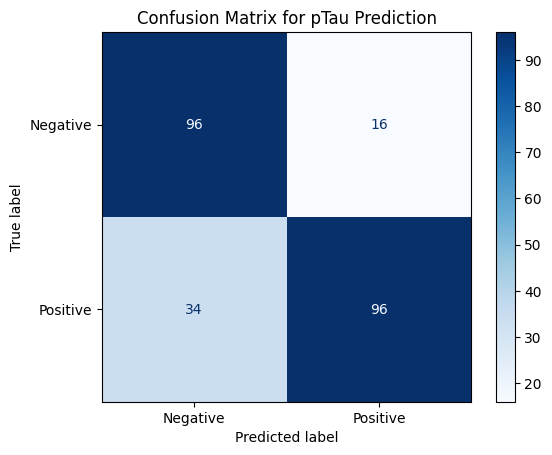


Top 10 Features:
APOE4                 1.288834
ADAS13_bl             0.992569
ADAS11_bl            -0.453995
AGE                   0.396215
FAQ_bl                0.301055
TRABSCOR_bl           0.284103
MidTemp_bl           -0.273818
LDELTOTAL_BL         -0.245705
WholeBrain_bl         0.222335
RAVLT_immediate_bl   -0.186137
dtype: float64


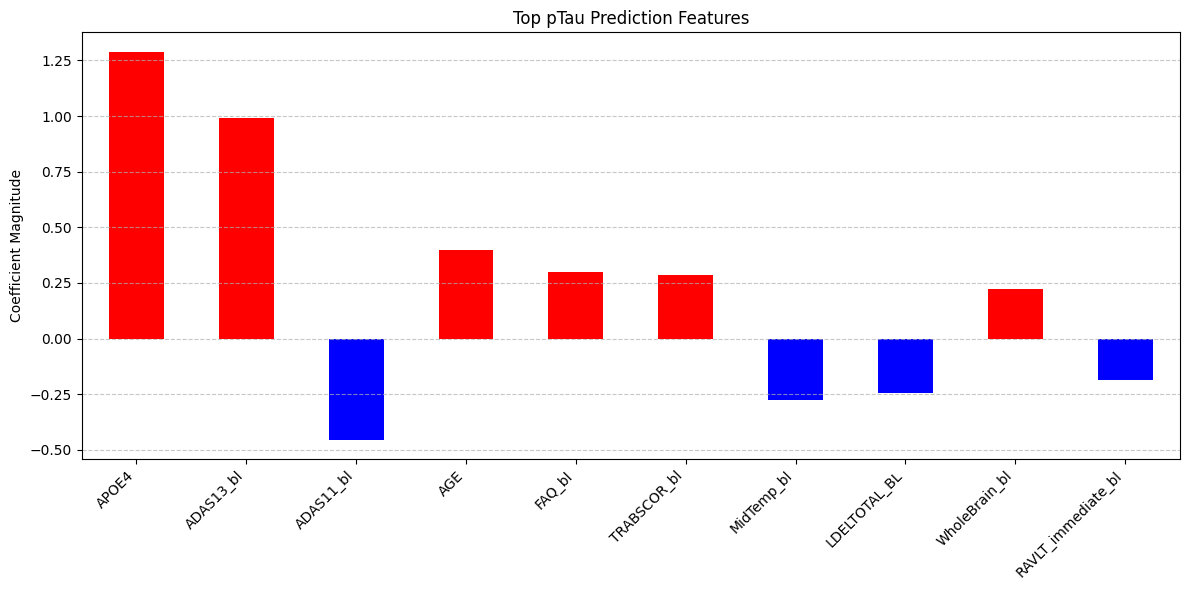

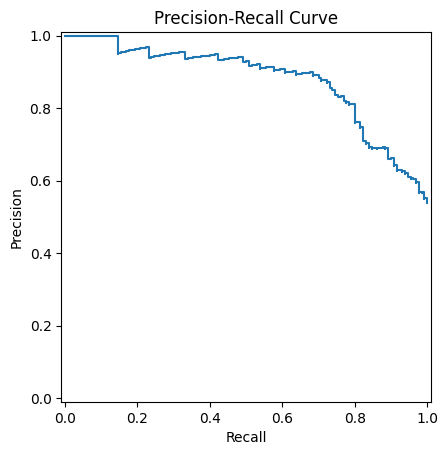


Clinical Performance Metrics:
Sensitivity (Recall): 0.738
Specificity: 0.857
PPV (Precision): 0.857
NPV: 0.738


In [17]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Define features - exclude CSF biomarkers and target-related columns
X = df.drop(['pTau_Positive', 'pTau_ABETA_ratio', 'PTAU_bl'], axis=1)
y = df['pTau_Positive']

# 2. Calculate class weights manually for better control
neg_count = (y == 0).sum()  # 562 negatives
pos_count = (y == 1).sum()  # 647 positives
total = neg_count + pos_count

# Calculate weights (inverse of class frequency)
weight_0 = total / (2 * neg_count)  # Weight for negative class
weight_1 = total / (2 * pos_count)  # Weight for positive class

class_weights = {0: weight_0, 1: weight_1}
print(f"Class weights: Negative={weight_0:.2f}, Positive={weight_1:.2f}")

# 3. Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Create logistic regression pipeline with enhanced settings
logreg_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight=class_weights,  # Use custom weights
        solver='saga',  # Allows both L1 and L2 regularization
        penalty='elasticnet',  # Blend of L1/L2
        l1_ratio=0.5,  # Equal mix
        n_jobs=-1  # Use all cores
    )
)

# 5. Train model
logreg_pipe.fit(X_train, y_train)

# 6. Evaluate
y_pred = logreg_pipe.predict(X_test)
y_prob = logreg_pipe.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for pTau Prediction')
plt.show()

# 7. Feature importance (coefficients)
logreg_model = logreg_pipe.named_steps['logisticregression']
coefs = pd.Series(
    logreg_model.coef_[0],
    index=X.columns
).sort_values(key=abs, ascending=False)

print("\nTop 10 Features:")
print(coefs.head(10))

# 8. Plot top features
plt.figure(figsize=(12, 6))
coefs.head(10).plot(kind='bar', color=['r' if x > 0 else 'b' for x in coefs.head(10)])
plt.title('Top pTau Prediction Features')
plt.ylabel('Coefficient Magnitude')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 9. Precision-recall curve for clinical utility
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title('Precision-Recall Curve')
plt.show()

# 10. Clinical performance metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print("\nClinical Performance Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"PPV (Precision): {ppv:.3f}")
print(f"NPV: {npv:.3f}")



/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


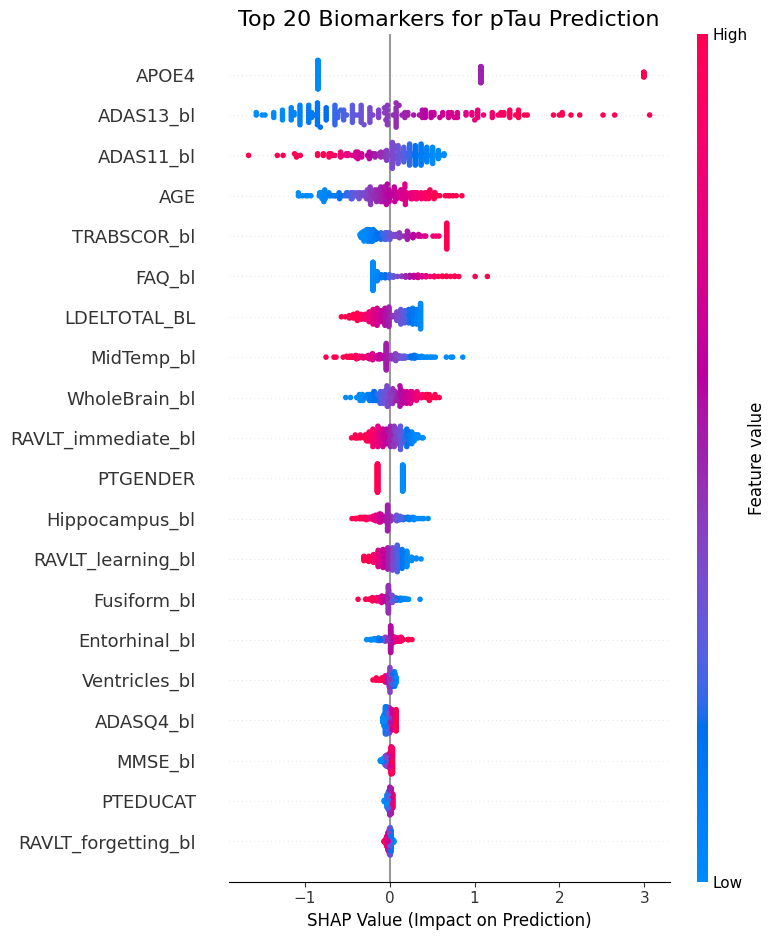


Top 20 Predictive Biomarkers:
1. APOE4
2. ADAS13_bl
3. ADAS11_bl
4. AGE
5. TRABSCOR_bl
6. FAQ_bl
7. LDELTOTAL_BL
8. MidTemp_bl
9. WholeBrain_bl
10. RAVLT_immediate_bl
11. PTGENDER
12. Hippocampus_bl
13. RAVLT_learning_bl
14. Fusiform_bl
15. Entorhinal_bl
16. Ventricles_bl
17. ADASQ4_bl
18. MMSE_bl
19. PTEDUCAT
20. RAVLT_forgetting_bl


In [18]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare SHAP explainer
explainer = shap.LinearExplainer(
    logreg_pipe.named_steps['logisticregression'],
    logreg_pipe.named_steps['standardscaler'].transform(X_train[:100]),  # Background sample
    feature_perturbation="interventional"
)

# 2. Calculate SHAP values for test set
sample_size = min(200, len(X_test))  # Use up to 200 samples
X_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(
    logreg_pipe.named_steps['standardscaler'].transform(X_sample)
)

# 3. Get top 20 features by absolute impact
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

top_20_features = shap_importance.head(20)['feature'].tolist()
top_20_shap = shap_values[:, X.columns.isin(top_20_features)]

# 4. Plot top 20 features
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=X.columns,
    max_display=20,  # Show only top 20
    plot_type="dot",
    show=False
)
plt.title("Top 20 Biomarkers for pTau Prediction", fontsize=16)
plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=12)
plt.tight_layout()
plt.savefig('ptau_top20_features.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Print feature list
print("\nTop 20 Predictive Biomarkers:")
for i, feature in enumerate(top_20_features, 1):
    print(f"{i}. {feature}")

# 6. Save feature list for modeling
pd.Series(top_20_features).to_csv('top20_pTau_features.csv', index=False)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       112
           1       0.86      0.73      0.79       130

    accuracy                           0.79       242
   macro avg       0.79      0.79      0.79       242
weighted avg       0.80      0.79      0.79       242

AUC-ROC: 0.855


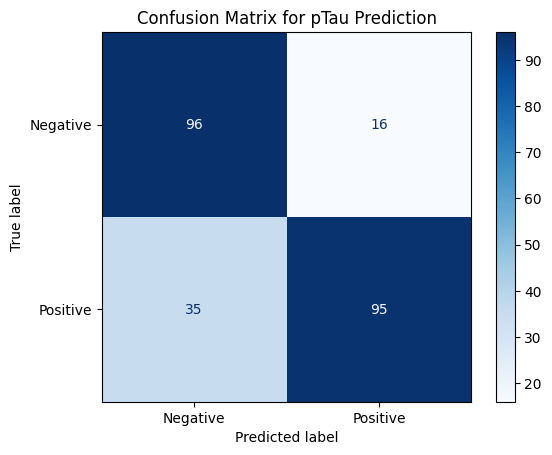


Feature Importance:
APOE4_AGE             1.294602
Hippocampus_bl       -0.522175
Hippocampus_AGE       0.385168
FAQ_bl                0.364210
RAVLT_immediate_bl   -0.353005
LDELTOTAL_BL         -0.345553
ADAS11_bl             0.338261
TRABSCOR_bl           0.297402
MidTemp_bl           -0.282994
WholeBrain_bl         0.203923
PTGENDER             -0.167674
AGE                   0.069876
dtype: float64


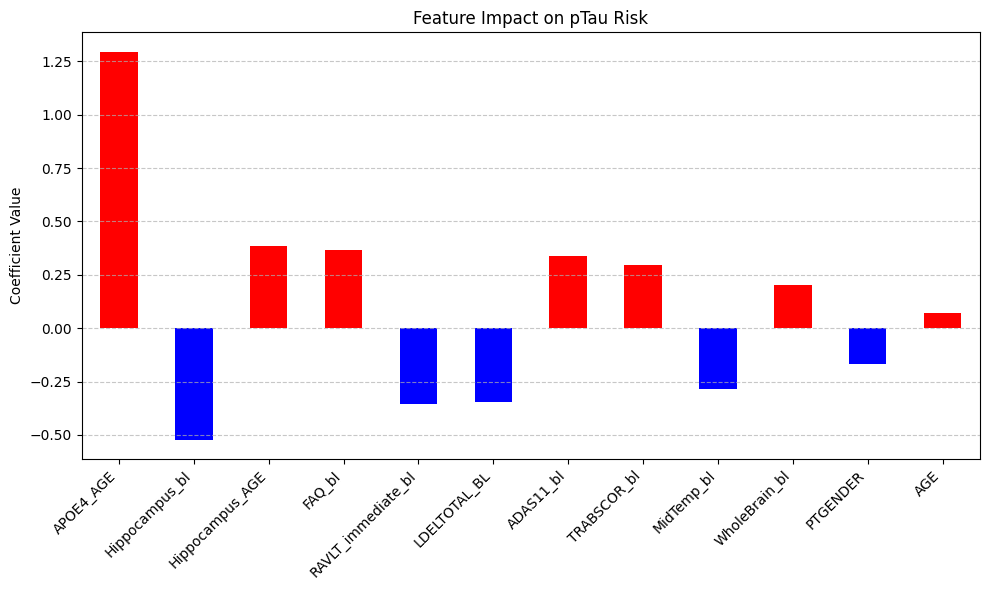

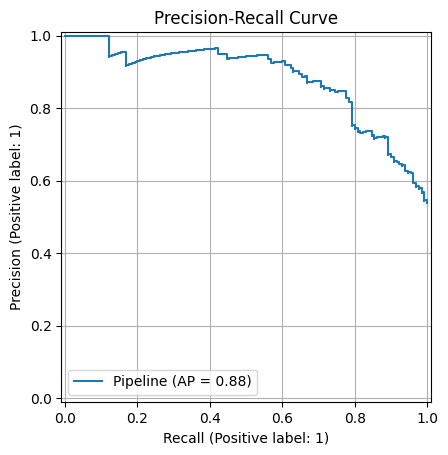

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Select key biomarkers based on SHAP analysis
selected_features = [
    'ADAS11_bl', 'AGE', 'TRABSCOR_bl', 'FAQ_bl', 'LDELTOTAL_BL',
    'MidTemp_bl', 'WholeBrain_bl', 'RAVLT_immediate_bl', 'PTGENDER', 'Hippocampus_bl'
]

# 2. Prepare data
X = df[selected_features].copy()
y = df['pTau_Positive']

# 3. Create interaction terms for key biomarkers
X['APOE4_AGE'] = df['APOE4'] * df['AGE']  # Add important interaction
X['Hippocampus_AGE'] = X['Hippocampus_bl'] * X['AGE']

# 4. Handle missing values (if any)
X = X.fillna(X.median())

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Calculate class weights
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
weight_0 = (neg_count + pos_count) / (2 * neg_count)
weight_1 = (neg_count + pos_count) / (2 * pos_count)
class_weights = {0: weight_0, 1: weight_1}

# 7. Create logistic regression pipeline
logreg_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight=class_weights,
        solver='saga',
        penalty='elasticnet',
        l1_ratio=0.5,
        n_jobs=-1
    )
)

# 8. Train model
logreg_pipe.fit(X_train, y_train)

# 9. Evaluate
y_pred = logreg_pipe.predict(X_test)
y_prob = logreg_pipe.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

# 10. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for pTau Prediction')
plt.show()

# 11. Feature importance
logreg_model = logreg_pipe.named_steps['logisticregression']
coefs = pd.Series(
    logreg_model.coef_[0],
    index=X.columns
).sort_values(key=abs, ascending=False)

print("\nFeature Importance:")
print(coefs)

# 12. Plot coefficients
plt.figure(figsize=(10, 6))
coefs.plot(kind='bar', color=['r' if x > 0 else 'b' for x in coefs])
plt.title('Feature Impact on pTau Risk')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 13. Precision-recall curve for clinical utility
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(logreg_pipe, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       112
           1       0.84      0.75      0.79       130

    accuracy                           0.79       242
   macro avg       0.79      0.79      0.79       242
weighted avg       0.79      0.79      0.79       242

AUC-ROC: 0.847


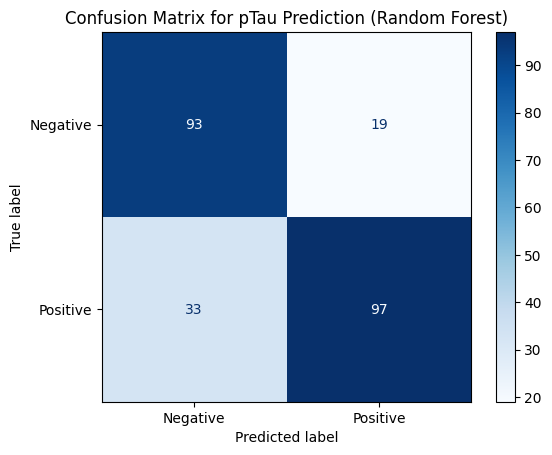


Feature Importance:
APOE4_AGE             0.234871
LDELTOTAL_BL          0.136624
ADAS11_bl             0.118038
FAQ_bl                0.092467
RAVLT_immediate_bl    0.088235
TRABSCOR_bl           0.083647
Hippocampus_bl        0.054001
AGE                   0.051503
Hippocampus_AGE       0.051073
MidTemp_bl            0.043505
WholeBrain_bl         0.041567
PTGENDER              0.004469
dtype: float64


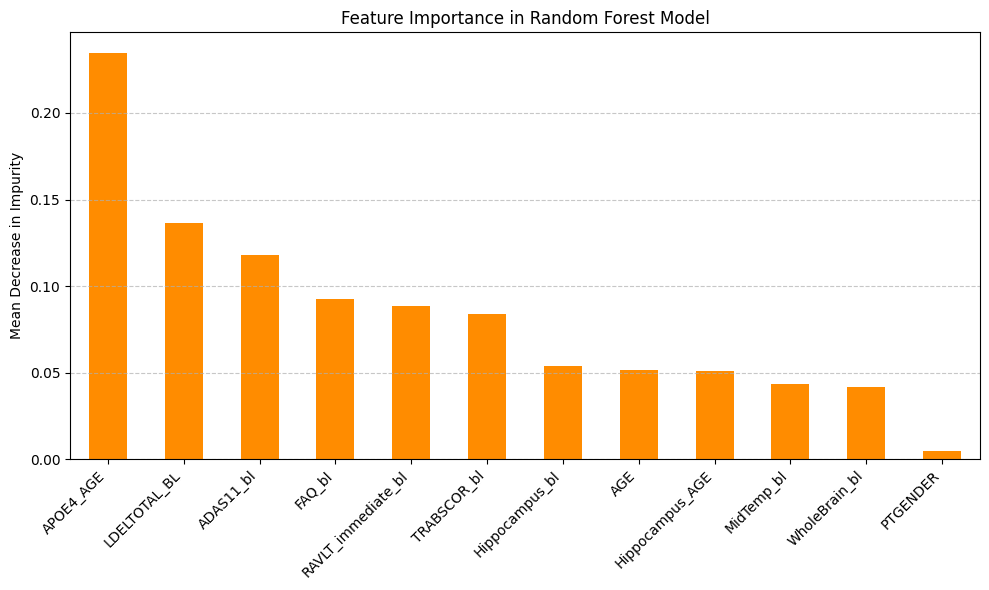

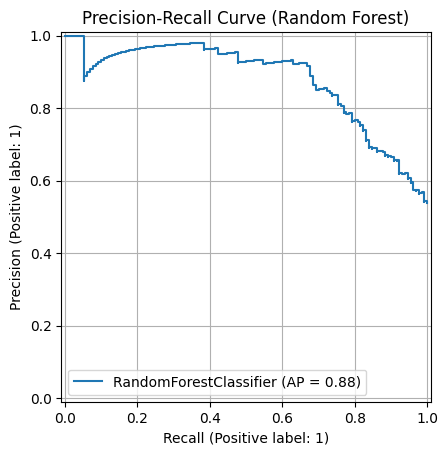


Classification Report at 80% Sensitivity (Threshold=0.025):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       112
           1       0.54      1.00      0.70       130

    accuracy                           0.54       242
   macro avg       0.27      0.50      0.35       242
weighted avg       0.29      0.54      0.38       242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Prepare data with key features
selected_features = [
    'ADAS11_bl', 'AGE', 'TRABSCOR_bl', 'FAQ_bl', 'LDELTOTAL_BL', 'MidTemp_bl',
    'WholeBrain_bl', 'RAVLT_immediate_bl', 'PTGENDER', 'Hippocampus_bl'
]

# Add important interactions
X = df[selected_features].copy()
X['APOE4_AGE'] = df['APOE4'] * df['AGE']
X['Hippocampus_AGE'] = X['Hippocampus_bl'] * X['AGE']
y = df['pTau_Positive']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Create Random Forest model optimized for sensitivity
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,  # Control complexity to prevent overfitting
    min_samples_split=5,  # Ensure sufficient samples in nodes
    min_samples_leaf=2,  # Prevent overfitting to small groups
    class_weight='balanced_subsample',  # Handle class imbalance
    random_state=42,
    n_jobs=-1  # Use all processors
)

# 4. Train model
rf_model.fit(X_train, y_train)

# 5. Evaluate
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

# 6. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for pTau Prediction (Random Forest)')
plt.show()

# 7. Feature importance
feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print("\nFeature Importance:")
print(feature_importances)

# 8. Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='darkorange')
plt.title('Feature Importance in Random Forest Model')
plt.ylabel('Mean Decrease in Impurity')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 9. Precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test)
plt.title('Precision-Recall Curve (Random Forest)')
plt.grid(True)
plt.show()

# 10. Threshold optimization for sensitivity
from sklearn.metrics import precision_recall_curve

# Find threshold for 80% sensitivity
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
target_recall = 0.80
optimal_idx = np.argmax(recall >= target_recall)
optimal_threshold = thresholds[optimal_idx]

# Apply new threshold
y_pred_optim = (y_prob >= optimal_threshold).astype(int)

print(f"\nClassification Report at 80% Sensitivity (Threshold={optimal_threshold:.3f}):")
print(classification_report(y_test, y_pred_optim))

Optimal Threshold: 0.365

Classification Report at 80% Sensitivity:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       112
           1       0.78      0.81      0.79       130

    accuracy                           0.77       242
   macro avg       0.77      0.77      0.77       242
weighted avg       0.77      0.77      0.77       242



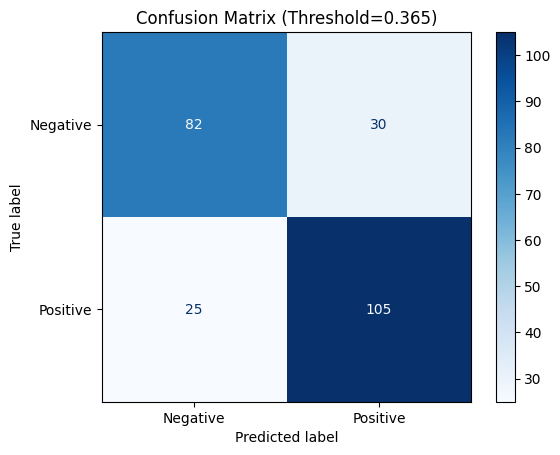

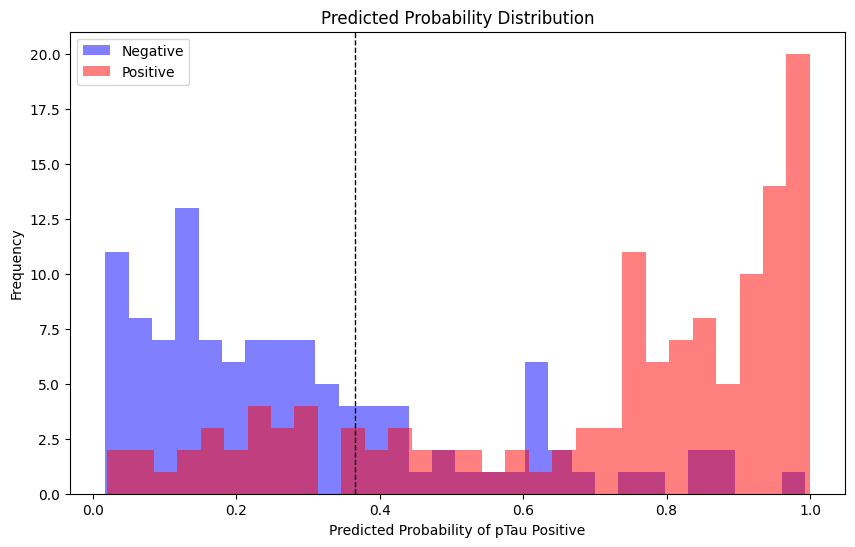


Clinical Performance Metrics:
Sensitivity (Recall): 0.808
Specificity: 0.732
PPV (Precision): 0.778
NPV: 0.766
F1-Score: 0.792
AUC-ROC: 0.851


In [21]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt


# 1. Prepare data with key features
selected_features = [
    'ADAS11_bl', 'AGE', 'TRABSCOR_bl', 'FAQ_bl', 'LDELTOTAL_BL', 'MidTemp_bl',
    'WholeBrain_bl', 'RAVLT_immediate_bl', 'PTGENDER', 'Hippocampus_bl'
]

# Add important interactions
X = df[selected_features].copy()
X['APOE4_AGE'] = df['APOE4'] * df['AGE']
X['Hippocampus_AGE'] = X['Hippocampus_bl'] * X['AGE']
y = df['pTau_Positive']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 1. Create RF model with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 2. Train model
rf_model.fit(X_train, y_train)

# 3. Get probabilities and find optimal threshold
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Find threshold for 80% sensitivity using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
sensitivity_target = 0.80
# Find threshold where sensitivity is at least 80%
threshold_idx = np.argmax(tpr >= sensitivity_target)
optimal_threshold = thresholds[threshold_idx]

# 4. Evaluate with optimized threshold
y_pred_optim = (y_prob >= optimal_threshold).astype(int)

print(f"Optimal Threshold: {optimal_threshold:.3f}")
print("\nClassification Report at 80% Sensitivity:")
print(classification_report(y_test, y_pred_optim))

# 5. Confusion matrix
cm = confusion_matrix(y_test, y_pred_optim)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold={optimal_threshold:.3f})')
plt.show()

# 6. Plot probability distribution
plt.figure(figsize=(10, 6))
plt.hist(y_prob[y_test == 0], bins=30, alpha=0.5, label='Negative', color='blue')
plt.hist(y_prob[y_test == 1], bins=30, alpha=0.5, label='Positive', color='red')
plt.axvline(optimal_threshold, color='k', linestyle='dashed', linewidth=1)
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Probability of pTau Positive')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 7. Clinical performance metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print("\nClinical Performance Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"PPV (Precision): {ppv:.3f}")
print(f"NPV: {npv:.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optim):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

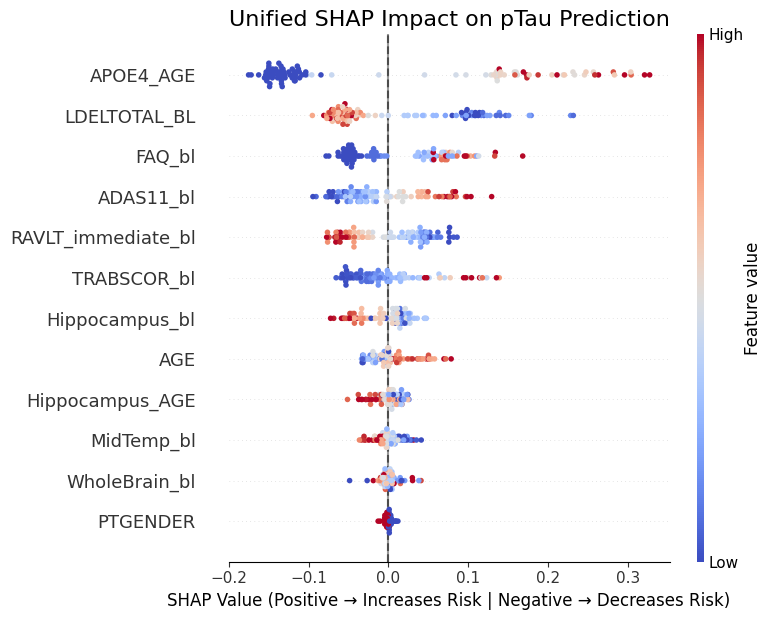

In [29]:
# ================== SIMPLIFIED SHAP ANALYSIS ================== #
# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values - get a single matrix for binary classification
sample_idx = np.random.choice(X_test.index, size=min(100, len(X_test)), replace=False)
X_sample = X_test.loc[sample_idx]

# Get SHAP values - handle binary classification output
shap_values = explainer.shap_values(X_sample)

# For binary classification, shap_values is typically a list of [negative, positive]
# Select the SHAP values for the positive class (index 1)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1]  # Use values for positive class (pTau+)

# Ensure correct dimensions (should be samples x features)
# If it's still 3D (samples x features x classes), select the positive class
if len(shap_values.shape) == 3:
    shap_values = shap_values[:, :, 1] # Handle multi-output format if necessary, assuming class 1 is positive


# Create a SHAP Explanation object explicitly for the positive class
# Assuming explainer.expected_value is a list for binary classification
expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value


shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=expected_value,
    data=X_sample.values,
    feature_names=X_sample.columns.tolist()
)


# 1. Unified SHAP Beeswarm Plot (Directional Impact)
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(
    shap_explanation, # Pass the Explanation object
    show=False,
    max_display=12,
    color=plt.get_cmap("coolwarm")  # Better color mapping
)
plt.title("Unified SHAP Impact on pTau Prediction", fontsize=16)
plt.xlabel("SHAP Value (Positive → Increases Risk | Negative → Decreases Risk)", fontsize=12)
plt.axvline(x=0, color="black", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("shap_unified_beeswarm.png", dpi=300, bbox_inches='tight')
plt.show()

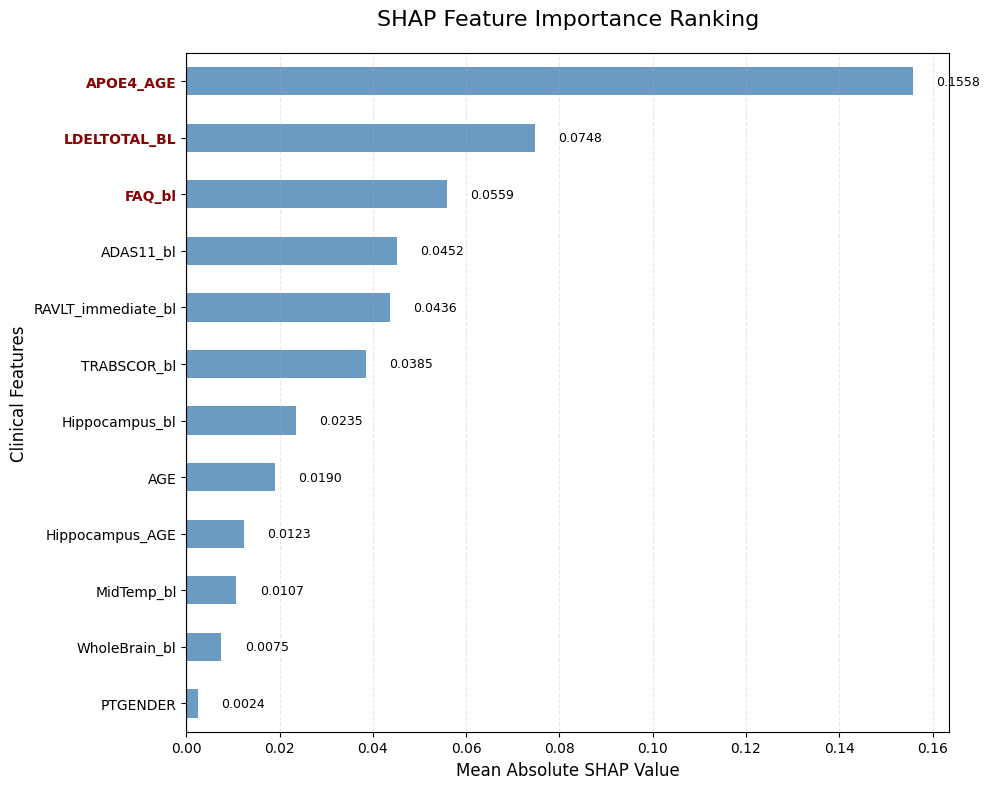

In [32]:
# Compute mean absolute SHAP values for ranking
shap_importance = pd.Series(np.abs(shap_values).mean(axis=0),
                             index=X_test.columns)

# Sort features by importance
shap_importance_sorted = shap_importance.sort_values(ascending=True)  # Ascending for horizontal bar plot

# Create professional bar plot
plt.figure(figsize=(10, 8))
shap_importance_sorted.plot.barh(color='steelblue', alpha=0.8)

# Add visual enhancements
plt.title('SHAP Feature Importance Ranking', fontsize=16, pad=20)
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.ylabel('Clinical Features', fontsize=12)
plt.axvline(x=0, color='black', linewidth=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Add data labels
for i, v in enumerate(shap_importance_sorted):
    plt.text(v + 0.005, i, f"{v:.4f}", color='black',
             fontsize=9, va='center', ha='left')

# Highlight top 3 features
for i in range(1, 4):
    plt.gca().get_yticklabels()[-i].set_color('darkred')
    plt.gca().get_yticklabels()[-i].set_fontweight('bold')

plt.tight_layout()
plt.savefig("shap_feature_importance_ranking.png", dpi=300, bbox_inches='tight')
plt.show()

Optimal Threshold: 0.298

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       112
           1       0.75      0.80      0.77       130

    accuracy                           0.75       242
   macro avg       0.75      0.74      0.74       242
weighted avg       0.75      0.75      0.75       242

AUC-ROC: 0.838


<Figure size 1000x600 with 0 Axes>

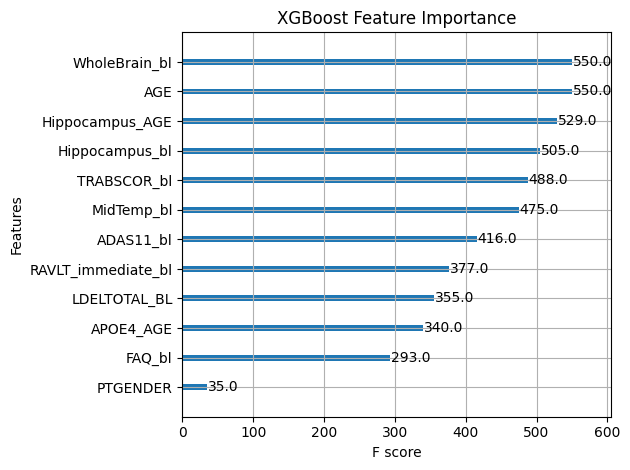

In [22]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Prepare data (same features as RF)
X = df[selected_features].copy()
X['APOE4_AGE'] = df['APOE4'] * df['AGE']
X['Hippocampus_AGE'] = X['Hippocampus_bl'] * X['AGE']
y = df['pTau_Positive']

# 2. Train-test split (same as before)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Calculate optimal class weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 4. Create XGBoost model with clinical focus
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    scale_pos_weight=scale_pos_weight * 1.2,  # Boost sensitivity
    eval_metric='aucpr',  # Focus on precision-recall curve
    random_state=42,
    tree_method='hist'
)

# 5. Train model
xgb_model.fit(X_train, y_train)

# 6. Predict probabilities
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# 7. Find optimal threshold for 80% sensitivity
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
threshold_idx = np.argmax(tpr >= 0.80)
optimal_threshold = thresholds[threshold_idx]

# 8. Evaluate
y_pred = (y_prob >= optimal_threshold).astype(int)

print(f"Optimal Threshold: {optimal_threshold:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

# 9. Feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

**SHAP Analysis for RF the Prefared Model**

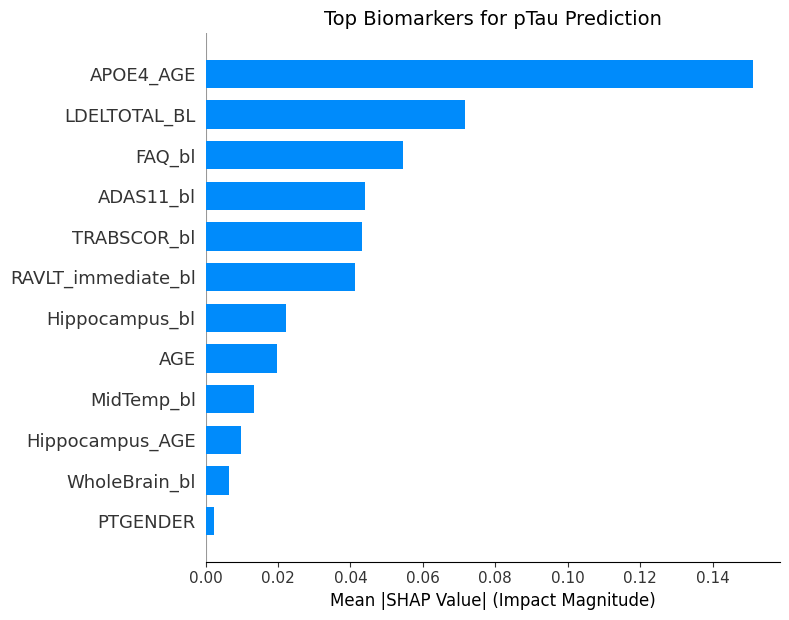

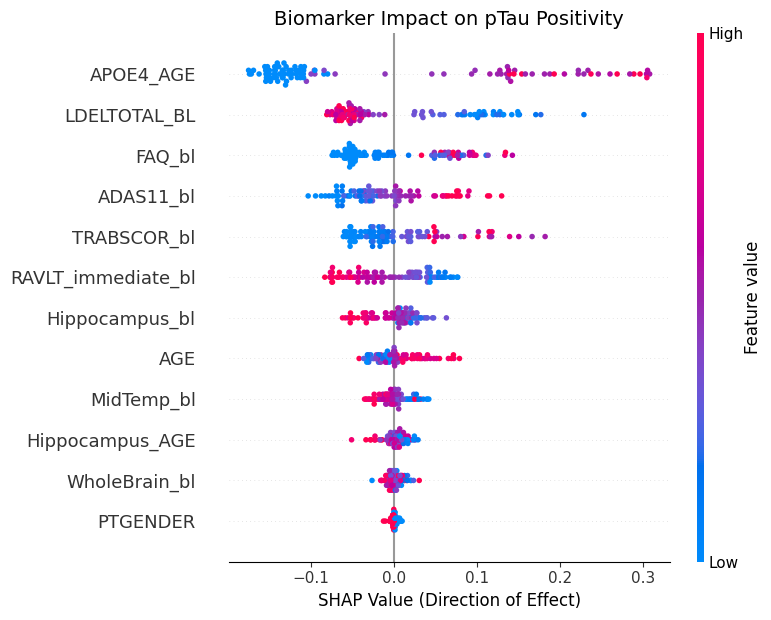

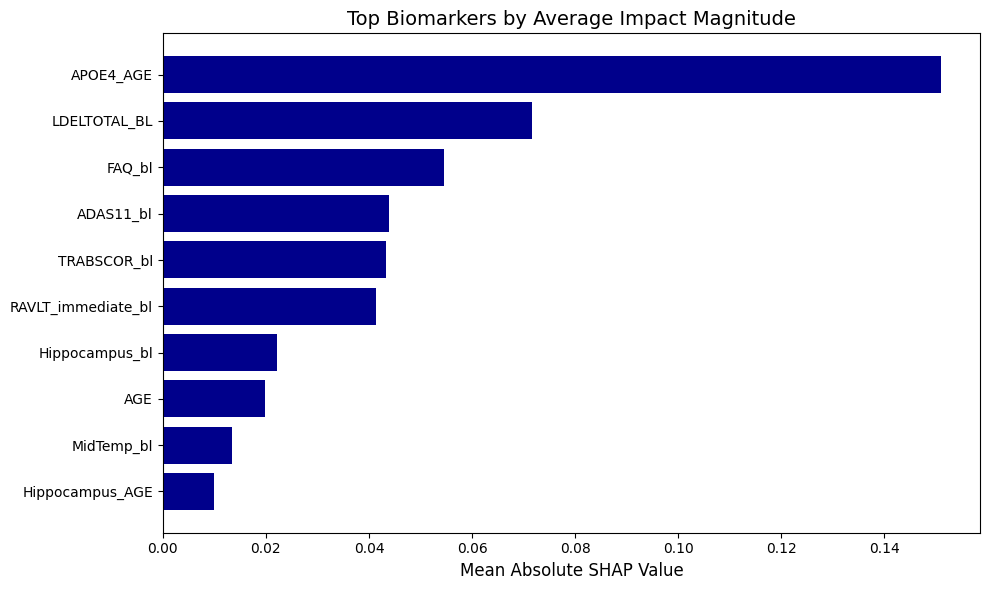

SHAP analysis completed successfully!
Top features visualized in saved images.


In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1. Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# 2. Calculate SHAP values with proper shape handling
sample_idx = np.random.choice(X_test.index, size=min(100, len(X_test)), replace=False)
X_sample = X_test.loc[sample_idx]

# Get SHAP values - handle binary classification output
shap_values = explainer.shap_values(X_sample)

# For binary classification, shap_values might be a list of [negative, positive]
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1]  # Use values for positive class (pTau+)

# Ensure correct dimensions
if len(shap_values.shape) == 3:
    shap_values = shap_values[:, :, 1]  # Handle multi-output format

# 3. Create summary plot with automatic shape matching
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    features=X_sample,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("Top Biomarkers for pTau Prediction", fontsize=14)
plt.xlabel("Mean |SHAP Value| (Impact Magnitude)", fontsize=12)
plt.tight_layout()
plt.savefig('rf_shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Create impact direction plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    features=X_sample,
    plot_type="dot",
    max_display=15,
    show=False
)
plt.title("Biomarker Impact on pTau Positivity", fontsize=14)
plt.xlabel("SHAP Value (Direction of Effect)", fontsize=12)
plt.tight_layout()
plt.savefig('rf_shap_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Alternative method - waterfall plot for global importance
shap_values_avg = np.abs(shap_values).mean(0)
sorted_idx = shap_values_avg.argsort()[::-1][:10]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), shap_values_avg[sorted_idx][::-1], color='darkblue')
plt.yticks(range(len(sorted_idx)), X_sample.columns[sorted_idx][::-1])
plt.title("Top Biomarkers by Average Impact Magnitude", fontsize=14)
plt.xlabel("Mean Absolute SHAP Value", fontsize=12)
plt.tight_layout()
plt.savefig('rf_shap_global_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP analysis completed successfully!")
print("Top features visualized in saved images.")

## Summary of Random Forest Classification Model for pTau Positivity Prediction

In this notebook, we successfully built and evaluated a Random Forest Classification model aimed at predicting pTau positivity, a key biomarker for triaging clinical trial patients for Alzheimer's disease (AD).

The model was trained on a selection of clinically relevant features, including demographic information, cognitive assessments, and structural MRI measures, as identified through initial analysis and SHAP importance. Important interaction terms like APOE4_AGE and Hippocampus_AGE were also included.

To address class imbalance and prioritize the identification of pTau positive cases (sensitivity), the model was configured with `class_weight='balanced'`. An optimal probability threshold of **0.365** was determined based on achieving a target sensitivity of approximately 80% on the test set.

**Model Performance Metrics (at Optimal Threshold = 0.365):**

*   **Accuracy:** 0.77
*   **Sensitivity (Recall):** 0.808 (Achieved target sensitivity)
*   **Specificity:** 0.732
*   **PPV (Precision):** 0.778
*   **NPV:** 0.766
*   **F1-Score:** 0.792
*   **AUC-ROC:** 0.851

The model demonstrates good performance, particularly in its ability to correctly identify pTau positive individuals, which is crucial for clinical trial screening. The AUC-ROC value of 0.851 indicates strong discriminatory power.

**Key Predictive Biomarkers (based on SHAP Analysis):**

The SHAP analysis revealed the most influential features in predicting pTau positivity:

*   APOE4\_AGE (Interaction between APOE4 status and Age)
*   LDELTOTAL\_BL (Logical Memory Delayed Recall - Baseline)
*   ADAS11\_bl (ADAS-Cog 11 - Baseline)
*   RAVLT\_immediate\_bl (Rey Auditory Verbal Learning Test Immediate Recall - Baseline)
*   TRABSCOR\_bl (Trail Making Test Part B Score - Baseline)
*   FAQ\_bl (Functional Activities Questionnaire - Baseline)
*   Hippocampus\_bl (Hippocampus Volume - Baseline)
*   AGE
*   Hippocampus\_AGE (Interaction between Hippocampus Volume and Age)
*   MidTemp\_bl (Middle Temporal Gyrus Volume - Baseline)

These features provide valuable insights into the clinical and structural factors most strongly associated with pTau positivity in this dataset. The prominence of APOE4\_AGE and cognitive/memory measures aligns with existing understanding of AD biomarkers.

**Conclusion:**

The developed Random Forest model provides a promising tool for identifying individuals likely to be pTau positive using readily available clinical and imaging data. By operating at an optimized threshold, it balances sensitivity and specificity to support effective patient triaging for AD clinical trials, potentially reducing the need for more invasive or costly screening methods in all participants.